In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pickle
import tensorflow_probability as tfp
tfd = tfp.distributions

In [6]:
tf.test.is_gpu_available()

True

In [7]:
def sample_data():
    count = 100000
    rand = np.random.RandomState(0)
    a = [[-1.5, 2.5]] + rand.randn(count // 3, 2) * 0.2
    b = [[1.5, 2.5]] + rand.randn(count // 3, 2) * 0.2
    c = np.c_[2 * np.cos(np.linspace(0, np.pi, count // 3)),
    -np.sin(np.linspace(0, np.pi, count // 3))]

    c += rand.randn(*c.shape) * 0.2
    data_x = np.concatenate([a, b, c], axis=0)
    data_y = np.array([0] * len(a) + [1] * len(b) + [2] * len(c))
    perm = rand.permutation(len(data_x))
    return data_x[perm], data_y[perm]

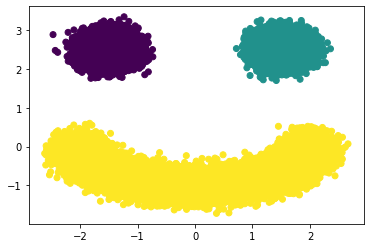

In [8]:
X, Y = sample_data()
X_train, Y_train = X[:80000,:], Y[:80000]
X_test, Y_test = X[-20000:,:], Y[-20000:]
plt.scatter(X_train[:,0], X_train[:,1], c=Y_train)

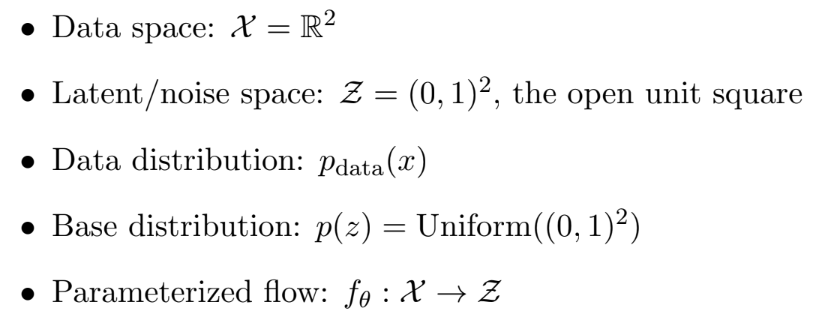

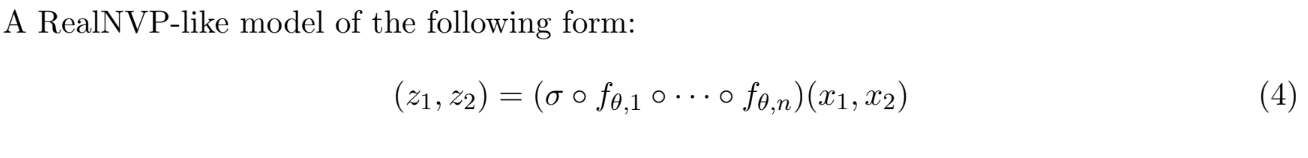

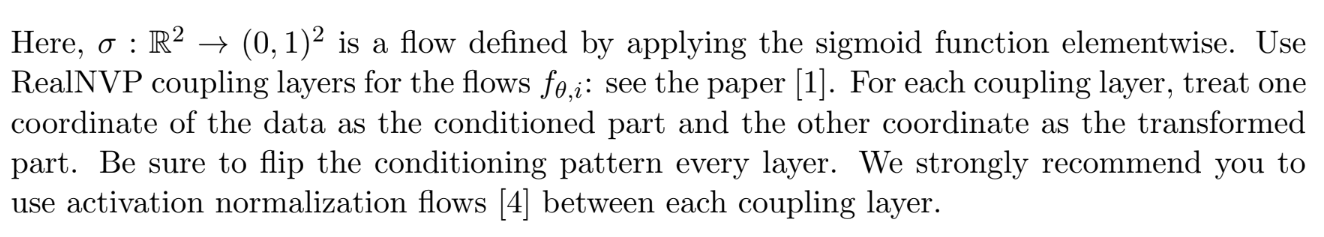

In [48]:
def dense(x, nrof_units, activation=None, training=True, use_batch_norm=False):
    x = tf.compat.v1.layers.Dense(units=nrof_units)(x)
    if use_batch_norm:
        x = tf.compat.v1.layers.BatchNormalization()(x, training=training)
    x = x if activation is None else activation(x)
    return x

def mlp(x, nrof_units, activation, nrof_layers=1, training=True):
    for _ in range(nrof_layers-1):
        x = dense(x, nrof_units=nrof_units, activation=activation, training=training)
    return x

def coupling_layer(x, nrof_units, nrof_layers, flip):
    x1, x2 = tf.split(x, num_or_size_splits=2, axis=1)
    if flip:
        x1, x2 = x2, x1
        
    y1 = x1
    sx = dense(mlp(x1, nrof_units=nrof_units, nrof_layers=nrof_layers, activation=tf.nn.leaky_relu), 
               nrof_units=1, activation=tf.nn.tanh)
    tx = dense(mlp(x1, nrof_units=nrof_units, nrof_layers=nrof_layers, activation=tf.nn.leaky_relu), 
               nrof_units=1, activation=None)
    y2 = x2*tf.exp(sx) + tx
    
    if flip:
        y1, y2 = y2, y1
    y = tf.concat([y1,y2], axis=1)
    log_det_jacobian = tf.reduce_sum(sx, axis=1)
    return y, log_det_jacobian

def real_nvp(x, nrof_layers, nrof_mlp_layers, nrof_mlp_units):
    log_det_jacobian_list = []
    
    # RealNVP coupling layers
    for i in range(nrof_layers):
        flip = i % 2 == 1
        x, log_det_jacobian = coupling_layer(x, nrof_units=nrof_mlp_units, nrof_layers=nrof_mlp_layers, flip=flip)
        log_det_jacobian_list += [ log_det_jacobian ]
        
    # Element-wise sigmoid
    x = tf.nn.sigmoid(x)
    log_det_sigmoid = tf.reduce_sum(tf.log((1.0-x)*x + 1e-3), axis=1)
    log_det_jacobian_list += [ log_det_sigmoid ]
            
    log_det_jacobian_tot = tf.add_n(log_det_jacobian_list)
    return x, log_det_jacobian_tot

In [ ]:
batch_size=100
nrof_epochs=20

tf.reset_default_graph()
with tf.Graph().as_default():

    x_ph = tf.placeholder(tf.float32, shape=(None, 2))
    
    x, log_det_jacobian = real_nvp(x_ph, nrof_layers=6, nrof_mlp_layers=4, nrof_mlp_units=10)
    base_dist = tfd.Independent(tfd.Uniform(low=[0, 0], high=[1, 1]), reinterpreted_batch_ndims=1)
    
    log_prob = base_dist.log_prob(x) + log_det_jacobian
    prob = tf.math.exp(log_prob)
    nll = -tf.reduce_mean(log_prob)
    
    loss = nll
    optimizer = tf.compat.v1.train.AdamOptimizer(learning_rate=0.0001)
    train_op = optimizer.minimize(loss)

    sess = tf.Session()
    sess.run(tf.compat.v1.global_variables_initializer())

    nrof_train_batches = int(np.floor(X_train.shape[0] / batch_size))
    train_loss_list = []
    for epoch in range(1, nrof_epochs+1):
        for i in range(nrof_train_batches):
            x_batch = X_train[i*batch_size:(i+1)*batch_size]
            _, loss_ = sess.run([train_op, loss], feed_dict={x_ph: x_batch})
            train_loss_list += [ loss_ ]
        
        if epoch % 1 == 0:
            print('train epoch: %d  loss: %.7f' % (epoch, loss_ / np.log(2)))
    test_loss_ = sess.run(loss, feed_dict={x_ph: X_test})
    print('Test NLL: %.3f bits/dim' % (test_loss_ / np.log(2)))
    
    plt.plot(np.array(train_loss_list) / np.log(2))


train epoch: 1  loss: 3.9572940
train epoch: 2  loss: 2.8928703
train epoch: 3  loss: 2.2998571
train epoch: 4  loss: 2.1312695
train epoch: 5  loss: 2.0640415
train epoch: 6  loss: 2.0380218
train epoch: 7  loss: 2.0168036
train epoch: 8  loss: 1.9975152
train epoch: 9  loss: 1.9870363
train epoch: 10  loss: 1.9718478
train epoch: 11  loss: 1.9655295
train epoch: 12  loss: 1.9688065
train epoch: 13  loss: 1.9726436
train epoch: 14  loss: 1.9712657
train epoch: 15  loss: 1.9752039


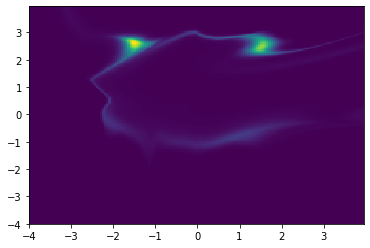

In [58]:
# Learned density
x_grid = np.arange(-4, 4, 0.05)
y_grid = np.arange(-4, 4, 0.05)
x1, x2 = np.meshgrid(x_grid, y_grid)
X_mesh = np.vstack([x1.flatten(),x2.flatten()]).T
prob_ = sess.run(prob, feed_dict={x_ph: X_mesh})
sz = int(np.sqrt(prob_.shape[0]))
_ = plt.pcolormesh(x_grid, y_grid, np.reshape(prob_, (sz,sz)))

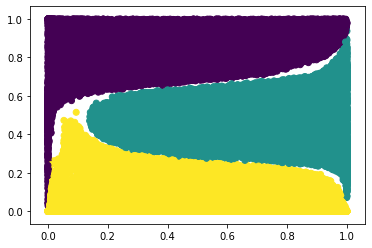

In [55]:
# Latent space
z_ = sess.run(x, feed_dict={x_ph: X_train[:60000,:]})
plt.scatter(z_[:,0], z_[:,1], c=Y_train[:60000])